In [8]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'SOC/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import torch
import pandas as pd
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler
import datetime
import numpy as np
import matplotlib.pyplot as plt
train_fraction = 0.9
seq_len = 10


Load Datset


In [13]:
df = pd.read_csv('/content/drive/Shareddrives/SoC 2022/SOC/RELIANCE.NS.csv')
del df['Date']
df

,Open,High,Low,Close,Adj Close,Volume
0,15.878770,15.956133,15.677626,15.793671,10.427811,77875009.0
1,16.052837,16.783918,15.878770,15.913584,10.506985,96602936.0
2,15.762726,15.813012,15.553845,15.766594,10.409934,100099436.0
3,15.704703,15.704703,15.522900,15.658285,10.338424,76935930.0
4,15.627340,15.638945,14.876918,15.031645,9.924682,86288584.0
...,...,...,...,...,...,...
6672,2507.199951,2597.000000,2501.000000,2580.149902,2580.149902,8863172.0
6673,2580.000000,2615.899902,2566.000000,2595.649902,2595.649902,10666627.0
6674,2574.899902,2592.000000,2365.000000,2408.699951,2408.699951,37841671.0
6675,2378.949951,2442.000000,2366.100098,2413.699951,2413.699951,19317335.0


Z-Score Normalization of dataset

In [17]:
scalerX = StandardScaler()
trans_data = scalerX.fit_transform(np.array(df))

1. Spliting datasets

In [34]:
train_size = int(len(trans_data)*train_fraction)
x_train = trans_data[:train_size]
x_test = trans_data[train_size:]
y_train =  trans_data[:train_size,4]
y_test = trans_data[train_size:,4]

z score normalisation


In [30]:
x_train.shape

(6009, 6)

In [35]:
y_train.shape

(6009,)

In [36]:
class StockMarketDataSet(Dataset):
  def __init__(self,x_data,y_data,seq_len=10):
    self.x_data = torch.from_numpy(np.array(x_data)).float()
    self.y_data = torch.from_numpy(np.array(y_data)).float().flatten()
    self.seq_len = seq_len
  def __len__(self):
    return len(self.x_data) - self.seq_len
  
  def __getitem__(self,index):
    return (self.x_data[index:index+self.seq_len].T,self.y_data[self.seq_len+ index])

In [37]:
train = StockMarketDataSet(x_train,y_train,seq_len)
test = StockMarketDataSet(x_test,y_test,seq_len)

In [38]:
class StockMarketPredictor(nn.Module):
  def __init__(self,input_size):
    super().__init__()
    self.cnn = nn.Conv1d(in_channels=input_size,out_channels=32,kernel_size=1,padding='same')
    self.pool = nn.MaxPool1d(kernel_size=1)
    self.lstm = nn.LSTM(input_size=32,num_layers=1,hidden_size=64,batch_first=True)
    self.fc = nn.Linear(64,1)
  def forward(self,x):
    x = self.cnn(x)
    x = torch.tanh(x)
    x = self.pool(x)
    x = torch.relu(x)
    x = torch.permute(x,(0,2,1))
    output,(h_n,c_n) = self.lstm(x)
    x = h_n[0]
    x = self.fc(x)
    x = torch.flatten(x)
    return x

In [39]:
batch_size = 64
training_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
testing_loader = DataLoader(test,batch_size=1,shuffle=True)

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
num_epochs = 10
learning_rate = 0.001
model = StockMarketPredictor(6)
# model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = torch.nn.L1Loss()

cuda:0


training time with  cuda:0 6.65973687171936


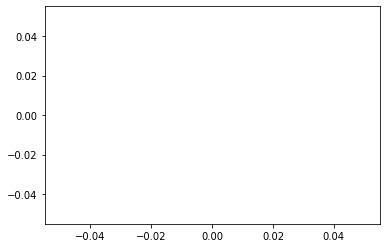

In [53]:
import time
start = time.time()
loss_arr = []
for e in range(num_epochs):
  for t,(x,y) in enumerate(training_loader):
    model.train()
    # x = x.to(device)
    # y = y.to(device)
    scores = model(x)
    loss = F.l1_loss(scores,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_arr.append(loss.item())
end = time.time()
print("training time with ",device,end-start)
loss_arr = np.array(loss_arr)
plt.plot(np.arange(loss_arr.shape[0]), loss_arr)

In [49]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [50]:
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(testing_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
LOSS train 0.0 valid nan
EPOCH 2:
LOSS train 0.0 valid nan
EPOCH 3:
LOSS train 0.0 valid nan
EPOCH 4:
LOSS train 0.0 valid nan
EPOCH 5:
LOSS train 0.0 valid nan


Testing


In [ ]:
pred_val = []
act_val = []
model.eval()
with torch.no_grad():
    total = 0
    total_losss = 0
    
    for t,(data, target) in enumerate(testing_loader):
        data = data.to(device)
        target = target.to(device)
        outputs = model(data)
        #pred_val.append(outputs.item)
        #act_val.append(target)
        loss = F.l1_loss(outputs,target)
        # print(data,outputs)
        # total_losss += loss.item()
        # total += len(target)
        # print(loss.item()/len(target))
        print(outputs,target)
# print(total_losss/total)
# pred_val = np.array(pred_val)
# act_val = np.array(act_val)
# plt.plot(np.arange(pred_val.shape[0]),pred_val)
# plt.plot(np.arange(act_val.shape[0]),act_val)